In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from keras import applications
from keras import layers
from keras import losses
from keras import ops
from keras import optimizers
from keras import metrics
from keras import Model
from keras.applications import resnet


target_shape = (200, 200)

2025-10-29 20:53:19.939777: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cache_dir = Path(Path.home()) / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

In [3]:
!gdown --id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown --id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

/home/xy/Desktop/ml/keras/test/keras_test/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
From (redirected): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34&confirm=t&uuid=75d9a392-e6b2-46fb-9c8b-695158cb881a
To: /home/xy/Desktop/ml/keras/test/left.zip
100%|████████████████████████████████████████| 104M/104M [00:03<00:00, 26.3MB/s]
/home/xy/Desktop/ml/keras/test/keras_test/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
From (redirected): https://drive.google.c

In [4]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [5]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

I0000 00:00:1761767623.420426   14652 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9034 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


2025-10-29 20:53:43.663889: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


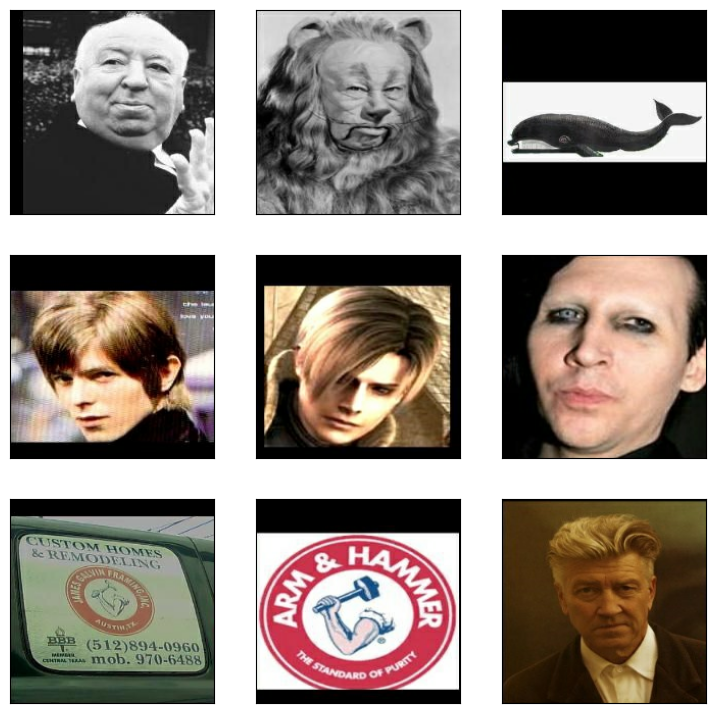

In [6]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [7]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [8]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = ops.sum(tf.square(anchor - positive), -1)
        an_distance = ops.sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [9]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [10]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


2025-10-29 20:53:53.839673: I external/local_xla/xla/service/service.cc:163] XLA service 0x752b9c004990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-29 20:53:53.839705: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-10-29 20:53:54.116957: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-29 20:53:57.000025: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300
2025-10-29 20:53:57.614935: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,50,50]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_cal

  1/151 ━━━━━━━━━━━━━━━━━━━━ 41:46 17s/step - loss: 2.2352

I0000 00:00:1761767641.791732   14775 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.7461

2025-10-29 20:54:27.189678: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[13,64,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,64,50,50]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-29 20:54:27.363547: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[13,128,25,25]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,128,25,25]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.7446

2025-10-29 20:54:40.241377: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[19,64,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,64,50,50]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-29 20:54:40.422184: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[19,128,25,25]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,128,25,25]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target

151/151 ━━━━━━━━━━━━━━━━━━━━ 57s 269ms/step - loss: 0.5184 - val_loss: 0.3764
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 33s 219ms/step - loss: 0.3967 - val_loss: 0.3716
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 35s 233ms/step - loss: 0.3738 - val_loss: 0.3512
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 236ms/step - loss: 0.3584 - val_loss: 0.3429
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 236ms/step - loss: 0.3369 - val_loss: 0.3405
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 238ms/step - loss: 0.3263 - val_loss: 0.3239
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 238ms/step - loss: 0.3261 - val_loss: 0.3039
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - loss: 0.3147 - val_loss: 0.2888
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - loss: 0.3083 - val_loss: 0.3024
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - loss: 0.2967 - val_loss: 0.3003


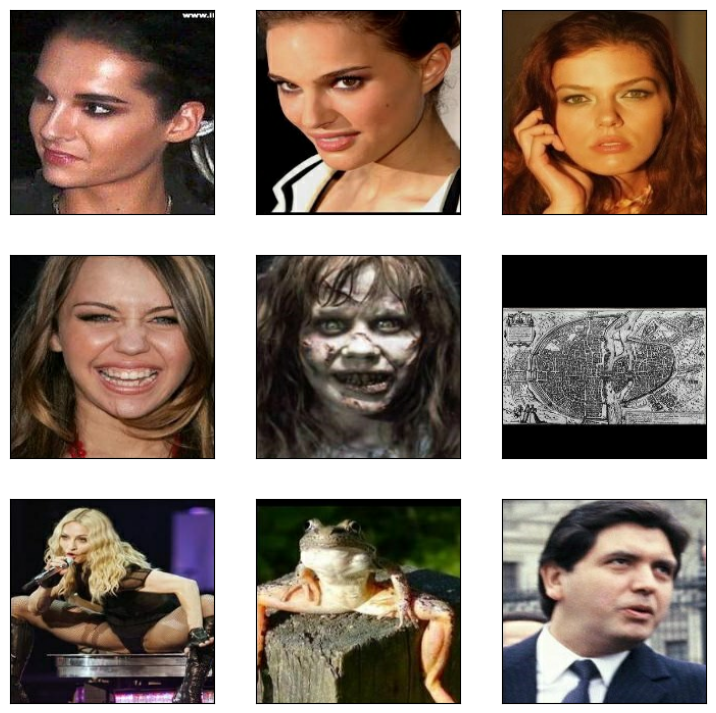

In [11]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [12]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9948572
Negative similarity 0.9932874
